# Classification accuracy assessment at Lemon Creek Glacier

Rainey Aberle

2022

In [1]:
# -----Import packages
import os
import glob
import numpy as np
import geopandas as gpd
import pandas as pd
import scipy
import xarray as xr
import rioxarray as rxr
import rasterio as rio
from shapely.geometry import Polygon
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics 
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import sys
import pickle
from joblib import dump, load

In [2]:
# -----Define paths in directory
site_name = 'LemonCreek'
# base directory (path to snow-cover-mapping/)
base_path = '/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/'
# path to classified points used to train and test classifiers
data_pts_path = '/Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/classified-points/'
# path to AOI shapefiles
AOI_path = data_pts_path + '../study-sites/' 

# -----Determine settings
terrain_parameters = False # whether to use terrain parameters (elevation, slope, aspect) in classification
save_figures = True # whether to save output figures

# -----Add path to functions
sys.path.insert(1, base_path + 'functions/')
import pipeline_utils as f

# -----Load dataset characteristics dictionary
with open(base_path + 'inputs-outputs/datasets_characteristics.pkl', 'rb') as fn:
    dataset_dict = pickle.load(fn)

# -----Load classified points
os.chdir(data_pts_path)
data_pts_fns = glob.glob('*LemonCreek*.shp')
data_pts_fns = sorted(data_pts_fns)
data_pts_fns

['LemonCreek_20210729_20_no-snow.shp',
 'LemonCreek_20210729_20_snow.shp',
 'LemonCreek_20210822_19_no-snow.shp',
 'LemonCreek_20210822_19_snow.shp']

In [3]:
gpd.read_file(data_pts_path+data_pts_fns[0])

,id,geometry
0,NaN,MULTIPOINT (-134.37366 58.40579)
1,NaN,MULTIPOINT (-134.37241 58.40535)
2,NaN,MULTIPOINT (-134.37045 58.40505)
3,NaN,MULTIPOINT (-134.36851 58.40574)
4,NaN,MULTIPOINT (-134.37111 58.40571)
...,...,...
395,NaN,MULTIPOINT (-134.36393 58.37686)
396,NaN,MULTIPOINT (-134.36583 58.37933)
397,NaN,MULTIPOINT (-134.36333 58.38066)
398,NaN,MULTIPOINT (-134.36627 58.37396)


## PlanetScope

In [5]:
# -----Load trained classifier and feature columns
clf_fn = base_path+'inputs-outputs/PlanetScope_classifier_all_sites.joblib'
clf = load(clf_fn)
feature_cols_fn = base_path+'inputs-outputs/PlanetScope_feature_columns.pkl'
feature_cols = pickle.load(open(feature_cols_fn,'rb'))

# -----Subset dataset dictionary
dataset = 'PlanetScope'
ds_dict = dataset_dict[dataset]

# -----Set up testing data
# path to images
im_path = data_pts_path + '../snowline-package/' + site_name + '/images/'
# determine number of images used for classified points
num_images = len([s for s in data_pts_fns if (site_name in s) and ('_snow.shp' in s)])
im_dates = [s[len(site_name)+1:len(site_name)+9] for s in data_pts_fns if (site_name in s) and ('_snow.shp' in s)]
# initialize full data frame
data_pts_full = gpd.GeoDataFrame()
# loop through each image
for j in range(0, num_images):
    # determine image date
    im_date = im_dates[j]
    # load classified points
    data_pts = pd.DataFrame() # dataframe to hold applicable data classes
    # no-snow
    if len([s for s in data_pts_fns if (site_name in s) and ('_no-snow.shp' in s) and (im_date in s)])>0: # check if class exists for site and date
        data_pts_snow_fn = [s for s in data_pts_fns if (site_name in s) and ('_no-snow.shp' in s) and (im_date in s)][0]
        data_pts_snow = gpd.read_file(data_pts_path + data_pts_snow_fn) # read file
        data_pts_snow['class'] = 0 # determine class ID
        data_pts = pd.concat([data_pts, data_pts_snow], ignore_index=True) # concatenate to full data points df
        # print(data_pts_snow_fn)
    # snow
    if len([s for s in data_pts_fns if (site_name in s) and ('_snow.shp' in s) and (im_date in s)])>0: # check if class exists for site and date
        data_pts_snow_fn = [s for s in data_pts_fns if (site_name in s) and ('_snow.shp' in s) and (im_date in s)][0]
        data_pts_snow = gpd.read_file(data_pts_path + data_pts_snow_fn) # read file
        data_pts_snow['class'] = 1 # determine class ID
        data_pts = pd.concat([data_pts, data_pts_snow], ignore_index=True) # concatenate to full data points df
        # print(data_pts_snow_fn)

    # Load image
    Idate = data_pts_snow_fn.index('_')+1
    im_fn = data_pts_snow_fn[Idate:Idate+11]+'_adj.tif' # image file name
    im_date = im_fn[0:4]+'-'+im_fn[4:6]+'-'+im_fn[6:8] # image capture date
    im = xr.open_dataset(im_path + im_fn)
    # remove no data values and account for image scalar
    im = im.where(im!=-9999)
    im = im / 1e4
    # define bands
    im['blue'] = im['band_data'][0]
    im['green'] = im['band_data'][1]
    im['red'] = im['band_data'][2]
    im['NIR'] = im['band_data'][3]
    im['NDSI'] = (im['green'] - im['NIR']) / (im['green'] + im['NIR'])    
    
    # reproject data points to image CRS
    data_pts = data_pts.to_crs(im.rio.crs)
    data_pts = data_pts.drop(columns=['id'])
    data_pts = data_pts.dropna()
    # grab x and y sample points
    x = [x.geoms[0].coords.xy[0][0] for x in data_pts.geometry]
    y = [x.geoms[0].coords.xy[1][0] for x in data_pts.geometry]
    # sample image values at data points
    for band in feature_cols:
        data_pts[band] = [im[band].sel(x=x, y=y, method='nearest').data for x, y in list(zip(x, y))]
    data_pts_full = pd.concat([data_pts_full, data_pts]) 
# Reduce memory usage in data pts
data_pts_full = data_pts_full.reset_index(drop=True)
data_pts_full = f.reduce_memory_usage(data_pts_full)

# -----Test the trained classifier
# features
X = data_pts_full[feature_cols] 
# target variable
y = data_pts_full['class'] 
# Predict class values using trained classifier
y_pred = clf.predict(X)
# Adjust outputs to only test snow and no-snow
y_pred[y_pred <= 2] = 1 # snow = 1, 2
y_pred[y_pred > 2] = 0 # no-snow = 3, 4, 5
# Calculate overall accuracy
accuracy = metrics.accuracy_score(y, y_pred)
# Calculate Kappa score
K = metrics.cohen_kappa_score(y, y_pred)
# Calculate confusion matrix
CM = metrics.confusion_matrix(y, y_pred)
# Print results
print('PlanetScope')
print('----------')
print('n='+str(len(y_pred)))
print('Overall accuracy: ' + str(accuracy))
print('Kappa score: ' + str(K))
print('Confusion matrix:')
CM


Mem. usage decreased to 0.09 Mb (12.5% reduction)
PlanetScope
----------
n=1998
Overall accuracy: 0.9434434434434434
Kappa score: 0.8864732769154184
Confusion matrix:


array([[ 874,   24],
       [  89, 1011]])

## Landsat

In [7]:
im_dates

['20210729', '20210822']

In [80]:
# -----Load trained classifier and feature columns
clf_fn = base_path+'inputs-outputs/Landsat_classifier_all_sites.joblib'
clf = load(clf_fn)
feature_cols_fn = base_path+'inputs-outputs/Landsat_feature_columns.pkl'
feature_cols = pickle.load(open(feature_cols_fn,'rb'))

# -----Subset dataset dictionary
dataset = 'Landsat'
ds_dict = dataset_dict[dataset]

# -----Set up testing data
# load image file names
im_fns = sorted(glob.glob(data_pts_path + 'LemonCreek_LC08*.tif'))
# initialize full data frame
data_pts_full_L = gpd.GeoDataFrame()
# loop through Landsat images
for i, im_fn in enumerate(im_fns):
    
    # load Landsat image as xarray.DataArray
    im_da = rxr.open_rasterio(im_fn)
    im_ds = xr.Dataset(  # convert to xarray.DataSet
        data_vars=dict(
            SR_B2=(["y", "x"], im_da.data[1]),
            SR_B3=(["y", "x"], im_da.data[2]),
            SR_B4=(["y", "x"], im_da.data[3]),
            SR_B5=(["y", "x"], im_da.data[4]),
            SR_B6=(["y", "x"], im_da.data[5]),
            SR_B7=(["y", "x"], im_da.data[6]),
        ),
        coords=dict(
            x = im_da.x.data,
            y = im_da.y.data
        )
    )
    im_ds = xr.where(im_ds<=0, np.nan, im_ds / ds_dict['image_scalar']) # remove no data values
    im_ds.rio.write_crs('EPSG:'+str(im_da.rio.crs.to_epsg()), inplace=True) # set CRS
    
    # load classified points
    # no-snow
    data_pts_no_snow_fn = [s for s in data_pts_fns if (site_name in s) and ('_no-snow.shp' in s) and (im_dates[i] in s)][0]
    data_pts_no_snow = gpd.read_file(data_pts_path + data_pts_no_snow_fn) # read file
    data_pts_no_snow['class'] = 0 # determine class ID
    # snow
    data_pts_snow_fn = [s for s in data_pts_fns if (site_name in s) and ('_snow.shp' in s) and (im_dates[i] in s)][0]
    data_pts_snow = gpd.read_file(data_pts_path + data_pts_snow_fn) # read file
    data_pts_snow['class'] = 1 # determine class ID
    # combine data pts, reproject to image CRS
    data_pts = pd.concat([data_pts_snow, data_pts_no_snow])
    data_pts = data_pts.to_crs('EPSG:'+str(im_da.rio.crs.to_epsg()))
    # drop any NaN points
    data_pts = data_pts.drop('id', axis=1)
    data_pts = data_pts.dropna()
    # grab x and y sample points
    x = [x.geoms[0].coords.xy[0][0] for x in data_pts.geometry]
    y = [x.geoms[0].coords.xy[1][0] for x in data_pts.geometry]
    # sample image values at data points
    for band in feature_cols[0:-1]:
        data_pts[band] = [im_ds[band].sel(x=x, y=y, method='nearest').data for x, y in list(zip(x, y))]
    # concatenate to data_pts_full
    data_pts_full_L = pd.concat([data_pts_full_L, data_pts])

# add NDSI column
data_pts_full_L['NDSI'] = ((data_pts_full_L[ds_dict['NDSI_bands'][0]] - data_pts_full_L[ds_dict['NDSI_bands'][1]]) 
                            /(data_pts_full_L[ds_dict['NDSI_bands'][0]] + data_pts_full_L[ds_dict['NDSI_bands'][1]]) )
# remove rows with no data
data_pts_full_L = data_pts_full_L.dropna().reset_index(drop=True)
# reduce memory usage in data pts
data_pts_full_L = f.reduce_memory_usage(data_pts_full_L)

# -----Test the trained classifier
# features
X = data_pts_full_L[feature_cols] 
# target variable
y = data_pts_full_L['class'].values
# Predict class values using trained classifier
y_pred = clf.predict(X)
# Adjust outputs to only test snow and no-snow
y_pred[y_pred <= 2] = 1 # snow = 1, 2
y_pred[y_pred > 2] = 0 # no-snow = 3, 4, 5
# Calculate overall accuracy
accuracy = metrics.accuracy_score(y, y_pred)
# Calculate Kappa score
K = metrics.cohen_kappa_score(y, y_pred)
# Calculate confusion matrix
CM = metrics.confusion_matrix(y, y_pred)
# Print results
print('Landsat')
print('----------')
print('Overall accuracy: ' + str(accuracy))
print('Kappa score: ' + str(K))
print('Confusion matrix:')
CM

Mem. usage decreased to 0.10 Mb (9.7% reduction)
Landsat
----------
Overall accuracy: 0.9152215799614644
Kappa score: 0.8284520923896712
Confusion matrix:


array([[607,   2],
       [130, 818]])

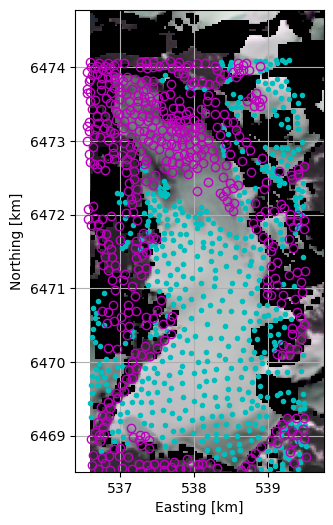

In [83]:
fig, ax = f.plot_xr_RGB_image(im_ds, ds_dict['RGB_bands'])
ax.plot([x.geoms[0].coords.xy[0][0]/1e3 for x in data_pts.loc[data_pts['class']==1, 'geometry']],
         [x.geoms[0].coords.xy[1][0]/1e3 for x in data_pts.loc[data_pts['class']==1, 'geometry']], '.c')
ax.plot([x.geoms[0].coords.xy[0][0]/1e3 for x in data_pts.loc[data_pts['class']==0, 'geometry']],
         [x.geoms[0].coords.xy[1][0]/1e3 for x in data_pts.loc[data_pts['class']==0, 'geometry']], 
         'o', markerfacecolor='none', markeredgecolor='m')
plt.show()

## Sentinel-2 SR

In [77]:
# -----Load trained classifier and feature columns
clf_fn = base_path+'inputs-outputs/Sentinel-2_SR_classifier_all_sites.joblib'
clf = load(clf_fn)
feature_cols_fn = base_path+'inputs-outputs/Sentinel-2_SR_feature_columns.pkl'
feature_cols = pickle.load(open(feature_cols_fn,'rb'))

# -----Subset dataset dictionary
dataset = 'Sentinel-2_SR'
ds_dict = dataset_dict[dataset]

# -----Set up testing data
# load image file names
im_fns = sorted(glob.glob(data_pts_path + 'LemonCreek_Sentinel-2_SR*.tif'))
# initialize full data frame
data_pts_full_S = gpd.GeoDataFrame()
# loop through Landsat images
for i, im_fn in enumerate(im_fns):
    
    # load Landsat image as xarray.DataArray
    im_da = rxr.open_rasterio(im_fn)
    im_ds = xr.Dataset( # convert to xarray.Dataset
                    data_vars=dict(
                        B2=(["y", "x"], im_da.data[1]),
                        B3=(["y", "x"], im_da.data[2]),
                        B4=(["y", "x"], im_da.data[3]),
                        B5=(["y", "x"], im_da.data[4]),
                        B6=(["y", "x"], im_da.data[5]),
                        B7=(["y", "x"], im_da.data[6]),
                        B8=(["y", "x"], im_da.data[7]),
                        B11=(["y", "x"], im_da.data[10]),
                        B12=(["y", "x"], im_da.data[11]),
                    ),
                    coords=dict(
                        x = im_da.x.data,
                        y = im_da.y.data
                    )
                )
    im_ds = xr.where(im_ds<=0, np.nan, im_ds / ds_dict['image_scalar']) # remove no data values
    im_ds.rio.write_crs('EPSG:'+str(im_da.rio.crs.to_epsg()), inplace=True) # set CRS
    
    # load classified points
    # no-snow
    data_pts_no_snow_fn = [s for s in data_pts_fns if (site_name in s) and ('_no-snow.shp' in s) and (im_dates[i] in s)][0]
    data_pts_no_snow = gpd.read_file(data_pts_path + data_pts_no_snow_fn) # read file
    data_pts_no_snow['class'] = 0 # determine class ID
    # snow
    data_pts_snow_fn = [s for s in data_pts_fns if (site_name in s) and ('_snow.shp' in s) and (im_dates[i] in s)][0]
    data_pts_snow = gpd.read_file(data_pts_path + data_pts_snow_fn) # read file
    data_pts_snow['class'] = 1 # determine class ID
    # combine data pts, reproject to image CRS
    data_pts = pd.concat([data_pts_snow, data_pts_no_snow])
    data_pts = data_pts.to_crs('EPSG:'+str(im_da.rio.crs.to_epsg()))
    # drop any NaN points
    data_pts = data_pts.drop('id', axis=1)
    data_pts = data_pts.dropna()
    # grab x and y sample points
    x = [x.geoms[0].coords.xy[0][0] for x in data_pts.geometry]
    y = [x.geoms[0].coords.xy[1][0] for x in data_pts.geometry]
    # sample image values at data points
    for band in feature_cols[0:-1]:
        data_pts[band] = [im_ds[band].sel(x=x, y=y, method='nearest').data for x, y in list(zip(x, y))]
    # concatenate to data_pts_full
    data_pts_full_S = pd.concat([data_pts_full_S, data_pts])

# add NDSI column
data_pts_full_S['NDSI'] = ((data_pts_full_S[ds_dict['NDSI_bands'][0]] - data_pts_full_S[ds_dict['NDSI_bands'][1]]) 
                            /(data_pts_full_S[ds_dict['NDSI_bands'][0]] + data_pts_full_S[ds_dict['NDSI_bands'][1]]) )
# remove rows with no data
data_pts_full_S = data_pts_full_S.dropna().reset_index(drop=True)
# reduce memory usage in data pts
data_pts_full_S = f.reduce_memory_usage(data_pts_full_S)

# -----Test the trained classifier
# features
X = data_pts_full_S[feature_cols] 
# target variable
y = data_pts_full_S['class'].values
# Predict class values using trained classifier
y_pred = clf.predict(X)
# Adjust outputs to only test snow and no-snow
y_pred[y_pred <= 2] = 1 # snow = 1, 2
y_pred[y_pred > 2] = 0 # no-snow = 3, 4, 5
# Calculate overall accuracy
accuracy = metrics.accuracy_score(y, y_pred)
# Calculate Kappa score
K = metrics.cohen_kappa_score(y, y_pred)
# Calculate confusion matrix
CM = metrics.confusion_matrix(y, y_pred)
# Print results
print('Sentinel-2_SR')
print('----------')
print('Overall accuracy: ' + str(accuracy))
print('Kappa score: ' + str(K))
print('Confusion matrix:')
CM

Mem. usage decreased to 0.10 Mb (7.9% reduction)
Sentinel-2_SR
----------
Overall accuracy: 0.8210361067503925
Kappa score: 0.60830553225689
Confusion matrix:


array([[309, 218],
       [ 10, 737]])

## Sentinel-2 TOA

In [79]:
# -----Load trained classifier and feature columns
clf_fn = base_path+'inputs-outputs/Sentinel-2_TOA_classifier_all_sites.joblib'
clf = load(clf_fn)
feature_cols_fn = base_path+'inputs-outputs/Sentinel-2_TOA_feature_columns.pkl'
feature_cols = pickle.load(open(feature_cols_fn,'rb'))

# -----Subset dataset dictionary
dataset = 'Sentinel-2_TOA'
ds_dict = dataset_dict[dataset]

# -----Set up testing data
# load image file names
im_fns = sorted(glob.glob(data_pts_path + 'LemonCreek_Sentinel-2_TOA*.tif'))
# initialize full data frame
data_pts_full_S = gpd.GeoDataFrame()
# loop through Landsat images
for i, im_fn in enumerate(im_fns):
    
    # load Landsat image as xarray.DataArray
    im_da = rxr.open_rasterio(im_fn)
    im_ds = xr.Dataset( # convert to xarray.Dataset
                    data_vars=dict(
                        B2=(["y", "x"], im_da.data[1]),
                        B3=(["y", "x"], im_da.data[2]),
                        B4=(["y", "x"], im_da.data[3]),
                        B5=(["y", "x"], im_da.data[4]),
                        B6=(["y", "x"], im_da.data[5]),
                        B7=(["y", "x"], im_da.data[6]),
                        B8=(["y", "x"], im_da.data[7]),
                        B11=(["y", "x"], im_da.data[10]),
                        B12=(["y", "x"], im_da.data[11]),
                    ),
                    coords=dict(
                        x = im_da.x.data,
                        y = im_da.y.data
                    )
                )
    im_ds = xr.where(im_ds<=0, np.nan, im_ds / ds_dict['image_scalar']) # remove no data values
    im_ds.rio.write_crs('EPSG:'+str(im_da.rio.crs.to_epsg()), inplace=True) # set CRS
    
    # load classified points
    # no-snow
    data_pts_no_snow_fn = [s for s in data_pts_fns if (site_name in s) and ('_no-snow.shp' in s) and (im_dates[i] in s)][0]
    data_pts_no_snow = gpd.read_file(data_pts_path + data_pts_no_snow_fn) # read file
    data_pts_no_snow['class'] = 0 # determine class ID
    # snow
    data_pts_snow_fn = [s for s in data_pts_fns if (site_name in s) and ('_snow.shp' in s) and (im_dates[i] in s)][0]
    data_pts_snow = gpd.read_file(data_pts_path + data_pts_snow_fn) # read file
    data_pts_snow['class'] = 1 # determine class ID
    # combine data pts, reproject to image CRS
    data_pts = pd.concat([data_pts_snow, data_pts_no_snow])
    data_pts = data_pts.to_crs('EPSG:'+str(im_da.rio.crs.to_epsg()))
    # drop any NaN points
    data_pts = data_pts.drop('id', axis=1)
    data_pts = data_pts.dropna()
    # grab x and y sample points
    x = [x.geoms[0].coords.xy[0][0] for x in data_pts.geometry]
    y = [x.geoms[0].coords.xy[1][0] for x in data_pts.geometry]
    # sample image values at data points
    for band in feature_cols[0:-1]:
        data_pts[band] = [im_ds[band].sel(x=x, y=y, method='nearest').data for x, y in list(zip(x, y))]
    # concatenate to data_pts_full
    data_pts_full_S = pd.concat([data_pts_full_S, data_pts])

# add NDSI column
data_pts_full_S['NDSI'] = ((data_pts_full_S[ds_dict['NDSI_bands'][0]] - data_pts_full_S[ds_dict['NDSI_bands'][1]]) 
                            /(data_pts_full_S[ds_dict['NDSI_bands'][0]] + data_pts_full_S[ds_dict['NDSI_bands'][1]]) )
# remove rows with no data
data_pts_full_S = data_pts_full_S.dropna().reset_index(drop=True)
# reduce memory usage in data pts
data_pts_full_S = f.reduce_memory_usage(data_pts_full_S)

# -----Test the trained classifier
# features
X = data_pts_full_S[feature_cols] 
# target variable
y = data_pts_full_S['class'].values
# Predict class values using trained classifier
y_pred = clf.predict(X)
# Adjust outputs to only test snow and no-snow
y_pred[y_pred <= 2] = 1 # snow = 1, 2
y_pred[y_pred > 2] = 0 # no-snow = 3, 4, 5
# Calculate overall accuracy
accuracy = metrics.accuracy_score(y, y_pred)
# Calculate Kappa score
K = metrics.cohen_kappa_score(y, y_pred)
# Calculate confusion matrix
CM = metrics.confusion_matrix(y, y_pred)
# Print results
print('Sentinel-2_TOA')
print('----------')
print('Overall accuracy: ' + str(accuracy))
print('Kappa score: ' + str(K))
print('Confusion matrix:')
CM

Mem. usage decreased to 0.10 Mb (7.9% reduction)
Sentinel-2_TOA
----------
Overall accuracy: 0.8036135113904164
Kappa score: 0.5736348948187764
Confusion matrix:


array([[311, 216],
       [ 34, 712]])